## Evaluate clustering using Silhouette Score.

## Evaluate clustering using Adjusted Rand index.

## Evaluate classification using the classification report.

In [3]:
ART_DIR = "artifacts"
RACE_COLS = ["pct_white","pct_black","pct_asian","pct_hispanic"]
ID_COL = "district_id"

================================================== \nVariant: full
Best k: 5 Silhouette: 0.2787602678607726
\nAverage racial composition:
              pct_white  pct_black  pct_asian  pct_hispanic
cluster_full                                               
0              0.504436   0.122780   0.088646      0.266013
1              0.215532   0.053561   0.022194      0.703642
2              0.545200   0.120486   0.055359      0.258385
3              0.148790   0.463236   0.065254      0.321616
4              0.124875   0.275041   0.040586      0.558801
Silhouette (recomputed): 0.2787602678607726


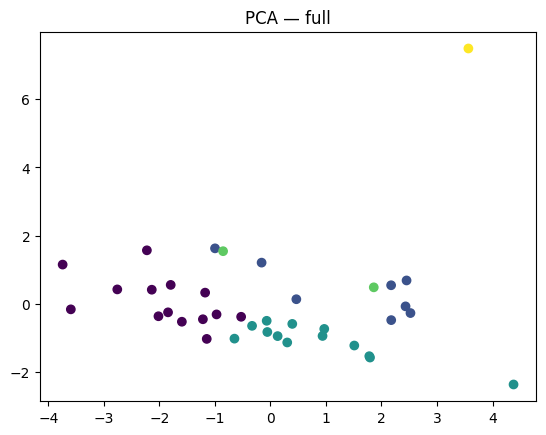

================================================== \nVariant: norace
Best k: 3 Silhouette: 0.4175162643399957
\nAverage racial composition:
                pct_white  pct_black  pct_asian  pct_hispanic
cluster_norace                                               
0                0.444635   0.135248   0.080298      0.324669
1                0.430637   0.117049   0.045186      0.391809
2                0.124875   0.275041   0.040586      0.558801
Silhouette (recomputed): 0.4175162643399957


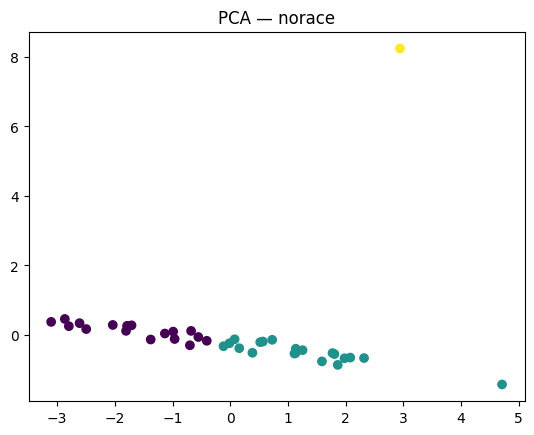

\nStability (ARI full vs. no-race): 0.5475434226583527


In [4]:
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_X(variant):
    return np.load(f"{ART_DIR}/X_{variant}_scaled.npz")["X"]

df = pd.read_csv(f"{ART_DIR}/dataset_snapshot.csv")

def eval_variant(variant):
    clusters_path = f"{ART_DIR}/clusters_{variant}.csv"
    meta_path = f"{ART_DIR}/trainmeta_{variant}.json"
    if not (os.path.exists(clusters_path) and os.path.exists(meta_path)):
        print("Missing", variant)
        return

    with open(meta_path) as f: meta = json.load(f)
    print("="*50, f"\\nVariant: {variant}")
    print("Best k:", meta["best_k"], "Silhouette:", meta["silhouette"])

    clusters = pd.read_csv(clusters_path)
    merged = df.merge(clusters, on=ID_COL, how="left")
    cluster_col = f"cluster_{variant}"

    if set(RACE_COLS).issubset(merged.columns):
        print("\\nAverage racial composition:")
        print(merged.groupby(cluster_col)[RACE_COLS].mean())

    X = load_X(variant)
    labels = merged[cluster_col]
    print("Silhouette (recomputed):", silhouette_score(X, labels))

    pca = PCA(2, random_state=42)
    Xt = pca.fit_transform(X)
    plt.scatter(Xt[:,0], Xt[:,1], c=labels)
    plt.title(f"PCA — {variant}")
    plt.show()

eval_variant("full")
eval_variant("norace")

# Compare stability
cf = pd.read_csv(f"{ART_DIR}/clusters_full.csv")
cn = pd.read_csv(f"{ART_DIR}/clusters_norace.csv")
m = cf.merge(cn, on=ID_COL)
ari = adjusted_rand_score(m["cluster_full"], m["cluster_norace"])
print("\\nStability (ARI full vs. no-race):", ari)